In [12]:
%cd ../../open-unmix-pytorch/

[Errno 2] No such file or directory: '../../open-unmix-pytorch/'
/home/nicolas/workspace/ma/ma4/ddspzart/workspace_2/open-unmix-pytorch


### Generic Imports

In [13]:
import scipy.signal
from IPython.display import Audio, display
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from matplotlib import gridspec
import warnings
import random
import sklearn.preprocessing
import norbert
import musdb
warnings.simplefilter(action='ignore', category=FutureWarning)

### Setup Vocal Separation Scenario

### Load a single track and convert to spectrogram

In [14]:
import torch.utils
import torch
import torch.utils.data

class SimpleMUSDBDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        subset='train',
        split='train',
        target='vocals',
        seq_duration=None,
    ):
        """MUSDB18 Dataset wrapper
        """
        self.seq_duration = seq_duration
        self.target = target
        self.mus = musdb.DB(
            download=True,
            split=split,
            subsets=subset,
        )

    def __getitem__(self, index):
        track = self.mus[index]
        track.chunk_start = random.uniform(0, track.duration - self.seq_duration)
        track.chunk_duration = self.seq_duration
        x = track.audio.T
        y = track.targets[self.target].audio.T
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


    def __len__(self):
        return len(self.mus)

Initialize the dataset

In [15]:
train_dataset = SimpleMUSDBDataset(seq_duration=5.0)
train_sampler = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
print(len(train_dataset))

80


Extract a single example

In [16]:
%pwd

'/home/nicolas/workspace/ma/ma4/ddspzart/workspace_2/open-unmix-pytorch'

torch.Size([2, 220500])
torch.Size([1, 1, 2049, 212])


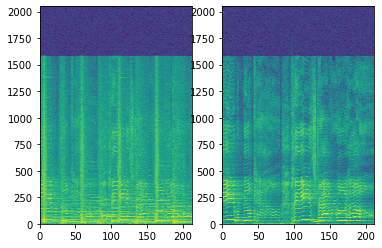

In [17]:
import openunmix

import torch.nn as nn

# create a spectrogram layer
stft = openunmix.transforms.TorchSTFT() # -> shape (nb_samples, nb_channels, nb_bins, nb_frames, complex=2)
spec = openunmix.transforms.ComplexNorm(mono=True) # -> shape (nb_samples, nb_channels(=1 if mono), nb_bins, nb_frames)
transform = nn.Sequential(stft, spec)

x, y = train_dataset[7]
print(x.shape)

# transform the time domain input to spectrograms
X = transform(x[None])
Y = transform(y[None])
print(X.shape)

f, axes = plt.subplots(1, 2)
axes[0].pcolormesh(np.log(X[0, 0, :, :].detach().numpy() ))
axes[1].pcolormesh(np.log(Y[0, 0, :, :].detach().numpy() ))

display(Audio(x, rate=44100))
display(Audio(y, rate=44100))


## Compute global mean and scale of Dataset

Sample from the dataset and update mean standard deviation using scikit-learn `StandardScaler`.

In [19]:
scaler = sklearn.preprocessing.StandardScaler()

for x, y in tqdm(train_dataset):
    X = transform(x[None]).T
    scaler.partial_fit(X.squeeze().numpy())

# set initial input scaler values
scale = np.maximum(
    scaler.scale_,
    1e-4*np.max(scaler.scale_)
)
mean = scaler.mean_

  0%|          | 0/80 [00:00<?, ?it/s]

/tmp/ipykernel_9378/1105133825.py:4: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2985.)
  X = transform(x[None]).T


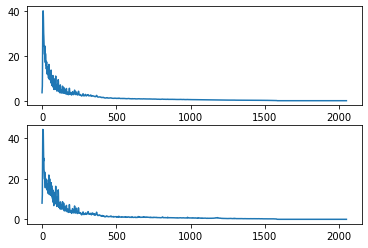

In [20]:
f, axes = plt.subplots(2, 1)
axes[0].plot(mean)
axes[1].plot(scale)


## Set up the model

In [21]:
use_cuda = torch.cuda.is_available()
torch.manual_seed(42)

device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [22]:
import torch.optim as optim

unmix = openunmix.model.OpenUnmix(
    input_mean=mean,
    input_scale=scale,
    nb_channels=1,
    hidden_size=512,
    max_bin=512,
    nb_bins=2048+1
).to(device)
    
optimizer = optim.RMSprop(unmix.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

# Train a vocal model 

In [23]:
y.shape

torch.Size([2, 220500])

In [25]:

losses = openunmix.utils.AverageMeter()
unmix.train()

for i in tqdm(range(1)):
    for x, y in tqdm(train_sampler):
        x, y = x.to(device), y.to(device)
        X = transform(x) #TODO does not work on my machine
        Y = transform(y)
        optimizer.zero_grad()
        Y_hat = unmix(X)
        loss = torch.nn.functional.mse_loss(Y_hat, Y)
        loss.backward()
        optimizer.step()
        losses.update(loss.item(), Y.size(1))
    print(losses.avg)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

RuntimeError: stft input and window must be on the same device but got self on cuda:0 and window on cpu

## Synthesize



In [ ]:
import musdb
mus = musdb.DB(download=True, subsets='test')
track = mus[1]

In [ ]:
print(Y.shape)
Y[..., 0].T.shape

torch.Size([8, 1, 2049, 212])


torch.Size([2049, 1, 8])

In [ ]:
# Define own separator
target_models = {"vocals": unmix}
own_separator = openunmix.model.Separator(target_models,nb_channels=1)
audio_torch = torch.tensor(track.audio.T[None, ...]).float().to(device)
print(audio_torch.shape)
own_separator.forward(audio_torch)

torch.Size([1, 2, 300032])


tensor([[[[ 0.0046, -0.0167,  0.0114,  ..., -0.0771, -0.0804, -0.0834],
          [ 0.1038,  0.1291,  0.1109,  ..., -0.0178, -0.0213, -0.0209]]]],
       grad_fn=<ReshapeAliasBackward0>)

In [ ]:
separator = openunmix.umxl()


In [ ]:
estimates = separator(audio_torch)
estimates.shape

In [ ]:
x = openunmix.predict.separate(audio_torch, rate=44_100 ,separator=own_separator)